In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from mpl_toolkits.mplot3d import Axes3D 
from skimage import measure, morphology
import os
import sys
from tqdm import tqdm
import tensorflow as tf
import time
import dill
import h5py
DATA_PATH = "3DMNIST_data/"


c:\users\icrdr\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with h5py.File(DATA_PATH+'full_dataset_vectors.h5', 'r') as hf:
    x_train_raw = hf["X_train"][:]
    y_train_raw = hf["y_train"][:]
    x_test_raw = hf["X_test"][:]
    y_test_raw = hf["y_test"][:]

x_train_raw = x_train_raw.reshape((10000,16,16,16))
x_test_raw = x_test_raw.reshape((2000,16,16,16))
print(x_test_raw[0].shape)
print(y_test_raw.shape)

(16, 16, 16)
(2000,)


2


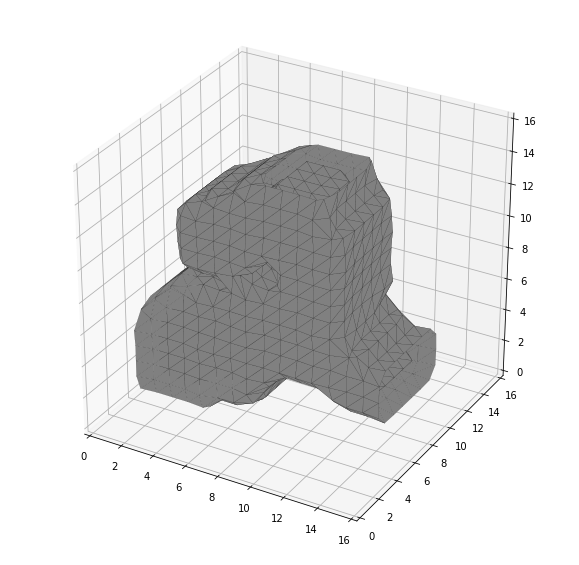

In [5]:
from mpl_toolkits.mplot3d import axes3d
def show3d(vols):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    vols = vols.transpose(1,2,0)
    verts, faces, normals, values  = measure.marching_cubes_lewiner(vols, 0.2)

    mesh = Poly3DCollection(verts[faces], facecolor="gray", edgecolor="black", alpha=0.5, linewidth=0.1)
    ax.add_collection3d(mesh)
    
    vols = np.array(vols > 0.05)
    
    #ax.voxels(vols, facecolors="gray", edgecolors="black", linewidth=0.1)
    
    ax.set_xlim(0, vols.shape[0])
    ax.set_ylim(0, vols.shape[1])
    ax.set_zlim(0, vols.shape[2])
    
i = 10
print(y_train_raw[i])
show3d(x_train_raw[i])

In [3]:
class Dataset:
    'dataset'
    def __init__(self, inputs, labels):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._inputs = inputs
        self._labels = labels
        self._num_examples = inputs.shape[0]
        pass
    
    @property
    def data(self):
        return self._inputs, self._labels

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        end = self._index_in_epoch + batch_size

        if end > self._num_examples or start==0: 
          # Finished epoch
          self._epochs_completed += 1
          # Shuffle the data
          p = np.arange(self._num_examples)
          np.random.shuffle(p)
          self._inputs = self._inputs[p]
          self._labels = self._labels[p]
          # Start next epoch
          start = 0
          end = batch_size
            
        self._index_in_epoch = end
        return self._inputs[start:end], self._labels[start:end]

dataset = Dataset(x_train_raw, y_train_raw)
x_batch, y_batch = dataset.next_batch(10);

print(y_batch)

[1 9 3 3 3 6 5 4 1 6]


In [9]:
def conv3d(x,deep,kernel,activation=tf.nn.relu):
    return tf.layers.conv3d(x, deep, kernel, strides=(1, 1, 1), padding='same', activation=activation)

def maxpool3d(x):
    return tf.layers.max_pooling3d(x, 2, strides=(2, 2, 2), padding='same')

def net(x, is_training):
    conv1_1 = conv3d(x, 32, 3)
    conv1_2 = conv3d(conv1_1, 32, 3, activation=None)
    conv1_2 = tf.layers.batch_normalization(conv1_2, training = is_training)
    conv1_2 = tf.nn.relu(conv1_2)
    
    p1= maxpool3d(conv1_2)
    
    conv2_1 = conv3d(p1, 64, 3)
    conv2_2 = conv3d(conv2_1, 64, 3)
    
    p2= maxpool3d(conv2_2)
    
    flat = tf.reshape(p2, [-1, 4 * 4 * 4 * 64])
    
    fc = tf.layers.dense(flat, 1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(fc, rate=0.5, training = is_training)
    return tf.layers.dense(fc, 10, activation=None)


x = tf.placeholder(tf.float32, [None,16,16,16])
y = tf.placeholder(tf.uint8)
is_training = tf.placeholder(tf.bool)
    
y_true =tf.one_hot(y, 10, on_value=1)
x_data = tf.expand_dims(x, -1)
    
logits = net(x_data, is_training)
losses = tf.losses.softmax_cross_entropy(onehot_labels = y_true, logits = logits)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(0.001).minimize(losses)
    
y_pred = tf.nn.softmax(logits)
correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(3000):
        x_batch, y_batch = dataset.next_batch(100);
        _, los, acc = sess.run(
            [train_step, losses, accuracy], 
            feed_dict={x:x_batch, y:y_batch, is_training: True}
        )
        
        if (i) % 100 == 0:
            test_acc = sess.run(
                    accuracy, 
                feed_dict={x:x_test_raw[:200], y:y_test_raw[:200], is_training:False}
            )
            print("step: %d, loss: %0.2f, test accuracy: %0.2f" % (i, los, test_acc))
        
    print("done!")

step: 0, loss: 2.51, test accuracy: 0.15
step: 100, loss: 1.16, test accuracy: 0.62
step: 200, loss: 1.17, test accuracy: 0.60
step: 300, loss: 0.89, test accuracy: 0.69
step: 400, loss: 0.79, test accuracy: 0.51
step: 500, loss: 0.48, test accuracy: 0.75
step: 600, loss: 0.42, test accuracy: 0.74
step: 700, loss: 0.47, test accuracy: 0.74
step: 800, loss: 0.27, test accuracy: 0.77
step: 900, loss: 0.39, test accuracy: 0.71
step: 1000, loss: 0.23, test accuracy: 0.74
step: 1100, loss: 0.21, test accuracy: 0.75
step: 1200, loss: 0.14, test accuracy: 0.73
step: 1300, loss: 0.12, test accuracy: 0.75
step: 1400, loss: 0.06, test accuracy: 0.76
step: 1500, loss: 0.06, test accuracy: 0.75
step: 1600, loss: 0.14, test accuracy: 0.74
step: 1700, loss: 0.01, test accuracy: 0.77
step: 1800, loss: 0.02, test accuracy: 0.76
step: 1900, loss: 0.13, test accuracy: 0.77
step: 2000, loss: 0.06, test accuracy: 0.78
step: 2100, loss: 0.04, test accuracy: 0.73
step: 2200, loss: 0.04, test accuracy: 0.77
